This script is used to derive the tagger SF and uncertainty on the signal.

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")
from make_stacked_hists import make_events_dict
import utils

plt.rcParams.update({"font.size": 20})

import json
import pickle as pkl
import warnings
from typing import List

import numpy as np
import scipy
from hist import Hist

def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
! ls ../eos/

Aug19_triggerSF_alpha_2016      Oct10_hww_2017_oldsignal
Aug19_triggerSF_alpha_2016APV   Oct10_hww_2018
Aug19_triggerSF_alpha_2017      Oct10_hww_2018_oldsignal
Aug19_triggerSF_alpha_2018      Oct10_hww_signal_2016
July18_hww_uselooselep_2016     Oct10_hww_signal_2016APV
July18_hww_uselooselep_2016APV  Oct10_hww_signal_2017
July18_hww_uselooselep_2017     Oct10_hww_signal_2018
July18_hww_uselooselep_2018     Oct10_hww_uselooselep_2016
July1_eleisoSF_2017             Oct10_hww_uselooselep_2016APV
July23_triggerSF_2016           Oct10_hww_uselooselep_2017
July23_triggerSF_2016APV        Oct10_hww_uselooselep_2018
July23_triggerSF_2017           Oct16_LP_2016
July23_triggerSF_2018           Oct16_LP_2016APV
June11_LP_2017                  Oct16_LP_2017
June1_LPvalidation_2017         Oct16_LP_2018
June21_zll_2016                 Oct2_hww_uselooselep_2016
June21_zll_2016APV              Oct2_hww_uselooselep_2016APV
June21_zll_2017                 Oct2_hww_uselooselep_2017
June21_zll_2018  

In [4]:
 # define your regions here
presel = {
        "mu": {
            "lepmiso": "(lep_pt<55) | ( (lep_pt>=55) & (lep_misolation<0.8))",   # needed for the fakes            

#             "jetvetomap": "jetvetomap==1",
            "msoftdrop": "fj_mass>40",
#             "THWW": "THWW>0.75",
            "bveto": "n_bjets_T==0",
            
#             "ggF": "( ( (mjj<1000) | (deta<3.5) ) )",
#             "VBF": "( (mjj>1000) & (deta>3.5) )",
        },
        "ele": {

#             "jetvetomap": "jetvetomap==1",            
            "msoftdrop": "fj_mass>40",
#             "THWW": "THWW>0.75",
            "bveto": "n_bjets_T==0",

#             "ggF": "( ( (mjj<1000) | (deta<3.5) ) )",
#             "VBF": "( (mjj>1000) & (deta>3.5) )",            
        },
}

if "ggF" in presel["mu"]:
    cat = "ggF"
else:
    cat = "VBF"

samples = [
    "ggF",
    "VBF",
    "WH",
    "ZH",
    "ttH",
]

channels = [
    "ele",
    "mu",
]

years = [
    "2016",
    "2016APV",
    "2017",
    "2018",
]

In [5]:
events_dict = {}

In [6]:
samples_dir = {
    "2016":    "../eos/Oct16_LP_2016",
    "2016APV": "../eos/Oct16_LP_2016APV",
    "2017":    "../eos/Oct16_LP_2017",
    "2018":    "../eos/Oct16_LP_2018",
}

THWW_path = "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx"

events_dict = make_events_dict(years, channels, samples_dir, samples, presel, THWW_path)

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying msoftdrop selection on 798 events
INFO:root:Applying bveto selection on 689 events
INFO:root:Will fill the VBF dataframe with the remaining 665 events
INFO:root:tot event weight 5.911151325749 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying msoftdrop selection on 1056 events
INFO:root:Applying bveto selection on 898 events
INFO:root:Will fill the WH dataframe with the remaining 866 events
INFO:root:tot event weight 0.8511535193811668 

INFO:root:Finding GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8 samples and should combine them under ggF
INFO:root:Applying msoftdrop selection on 0 events
INFO:root:Applying bveto selection on 0 events
INFO:root:Will fill the ggF dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and sh

INFO:root:tot event weight 19.653275959041466 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying lepmiso selection on 2638 events
INFO:root:Applying msoftdrop selection on 2638 events
INFO:root:Applying bveto selection on 2215 events
INFO:root:Will fill the WH dataframe with the remaining 2127 events
INFO:root:tot event weight 2.530288557020678 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:Applying lepmiso selection on 5830 events
INFO:root:Applying msoftdrop selection on 5830 events
INFO:root:Applying bveto selection on 5411 events
INFO:root:Will fill the ttH dataframe with the remaining 2507 events
INFO:root:tot event weight 4.633931453029133 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under ZH
INFO:root:Applying lepmiso selection on 5636 events
INFO:root:Applying msoftdrop selection on 5636 events
INFO:root:Applying bveto selection on 4737 events
INFO:root:Will fill the

INFO:root:tot event weight 30.899303245368834 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying lepmiso selection on 7423 events
INFO:root:Applying msoftdrop selection on 7423 events
INFO:root:Applying bveto selection on 6172 events
INFO:root:Will fill the WH dataframe with the remaining 5982 events
INFO:root:tot event weight 4.243204474084796 

INFO:root:Finding GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8 samples and should combine them under ggF
INFO:root:Applying lepmiso selection on 2 events
INFO:root:Applying msoftdrop selection on 2 events
INFO:root:Applying bveto selection on 1 events
INFO:root:Will fill the ggF dataframe with the remaining 1 events
INFO:root:tot event weight 0.6542087730321038 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:Applying lepmiso selection on 7238 events
INFO:root:Applying msoftdrop selection on 7238 events
INFO:root:Applying b

In [7]:
channels_to_combine = [
    "ele",
    "mu",
]

years_to_combine = [
    "2016",
    "2016APV",
    "2017",
    "2018",
]

df_combined = []
for year in years_to_combine:
    for ch in channels_to_combine:
        print(year, ch)
        for sig in samples:
            df_combined.append(events_dict[year][ch][sig])

df_combined = pd.concat(df_combined)

2016 ele
2016 mu
2016APV ele
2016APV mu
2017 ele
2017 mu
2018 ele
2018 mu


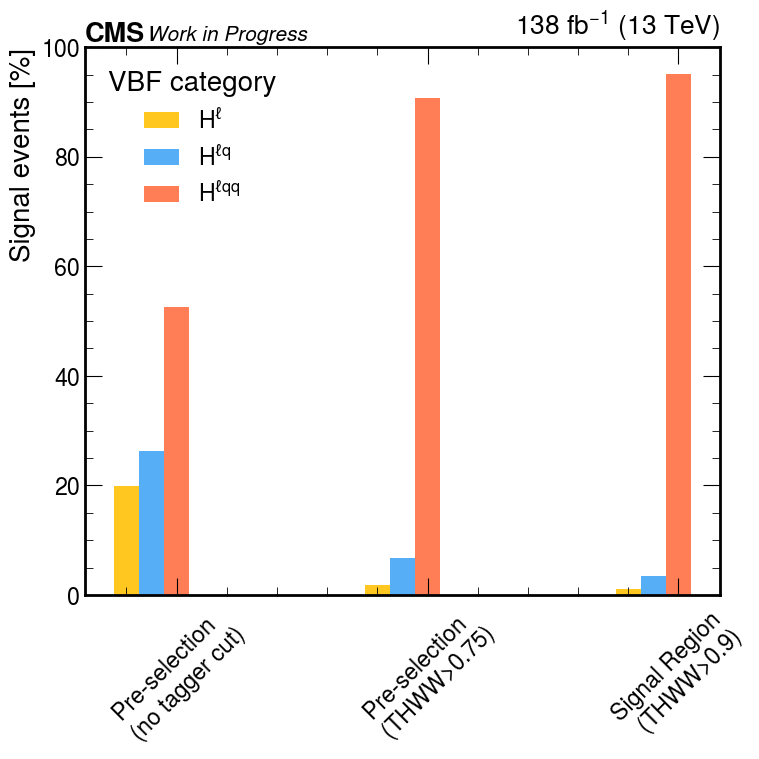

In [8]:
############################################# Config
%matplotlib inline
plt.rcParams.update({"font.size": 20})

# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

# color_by_sample = {
#     0: "tab:orange", 
#     1: "tab:blue",
#     2: "tab:green",
# }
color_by_sample = ['#FFC107', '#42A5F5', '#FF7043', '#66BB6A', '#EF5350', '#BDBDBD']

regions = {
    "Pre-selection \n (no tagger cut)": 0,
    "Pre-selection \n (THWW>0.75)": 0.75,
    "Signal Region \n (THWW>0.9)": 0.9,
}
#############################################

is_hww_l = (df_combined["num_m_quarks"]==0)
is_hww_lq = (df_combined["num_m_quarks"]==1)
is_hww_lqq = (df_combined["num_m_quarks"]==2)

num_topologies = 3
bar_width = 0.1

fig, ax = plt.subplots(figsize=(8, 8))

for iregion, (region, cut) in enumerate(regions.items()):

    for i, (key, var) in enumerate(
        {
            r"$\mathrm{H}^{\ell}$": is_hww_l,
            r"$\mathrm{H}^{{\ell}q}$": is_hww_lq,
            r"$\mathrm{H}^{{\ell}qq}$": is_hww_lqq,
        }.items()
    ):

        X = 100 * (var & (df_combined["THWW"]>cut)).sum() / sum(df_combined["THWW"]>cut)
        bars = ax.bar(
            iregion + i * bar_width, 
            X, 
            bar_width, 
            color=color_by_sample[i],
            label=key,
            alpha=0.9,
        )

# Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
# ax.set_ylim(-2.5, 2.5)

# Adjust the number of x-tick labels to match the number of groups
plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

# Add a legend
handles, labels = ax.get_legend_handles_labels()[0][:num_topologies], ax.get_legend_handles_labels()[1][:num_topologies]
ax.legend(handles, labels, loc='upper left', title=f"{cat} category")

ax.set_ylabel("Signal events [%]")
ax.set_ylim(0,100)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/LP_mquarks_{cat}.pdf")    

In [9]:
# import vector 
# # Create 4-vectors from px, py, pz, and energy
# vec = vector.array({
#     "px": pxs,
#     "py": pys,
#     "pz": pzs,
#     "E": Es,
# })

# # Now you can access pt, eta, phi, and energy components
# pts = vec.pt
# etas = vec.eta
# phis = vec.phi
# energies = vec.E  # Energy remains unchanged

# # Stack these new vectors back into a new array
# new_pf_cands = np.stack([pts, etas, phis, energies], axis=-1)

## Retrieve the pfcands, genquark, and ak8 jet info

In [10]:
def ang_dist(phi1, phi2):
    phi1 = phi1 % (2. * np.pi)
    phi2 = phi2 % (2. * np.pi)
    dphi = phi1 - phi2
    if(len(dphi.shape) > 0):
        dphi[dphi < -np.pi] += 2.*np.pi
        dphi[dphi > np.pi] -= 2.*np.pi
    else:
        if(dphi < -np.pi): dphi += 2.*np.pi
        if(dphi > np.pi): dphi -= 2.*np.pi

    return dphi

def get_dRs_columnar(gen_eta_phi, j_4vec):

    dR = np.sqrt(np.square(gen_eta_phi[:, :,0] - j_4vec[:, 1]) + 
            np.square(ang_dist(gen_eta_phi[:, :,1], j_4vec[:, 2] )))
    return dR

########### combine all years and channels under one key
def combine_channels(years, channels, events_dict, sample):

    for year in years:
        for ch in channels:

            df = []
            df.append(events_dict[year][ch][sample])

        events_dict[year]["lep"] = {}
        events_dict[year]["lep"][sample] = pd.concat(df)
    
    return events_dict

if cat == "VBF":
    score_thresh = 0.905
else:
    score_thresh = 0.93

In [11]:
score_thresh

0.905

In [12]:
########### combine all signal under one key

samples_to_combine = [
    "ggF",
    "VBF",
#     "WH",
#     "ZH",
#     "ttH",
]

for year in years:
    for ch in channels:

        df = []
        for sig in samples_to_combine:
            df.append(events_dict[year][ch][sig])        
        events_dict[year][ch]["Signal"] = pd.concat(df)

In [13]:
pd.options.mode.copy_on_write = False
pd.options.mode.chained_assignment = None

years_LP = [
    "2018",
    "2017",
    "2016",
    "2016APV",
]
channels_LP = [
    "lep",
]

sample = "Signal"
# sample = "VBF"
# sample = "ggF"
# sample = "ttH"
events_dict = combine_channels(years, channels, events_dict, sample)

Whad = ""
save_dict = True

for year in years_LP:
    print(year)
    for ch in channels_LP:

        df = events_dict[year][ch][sample]

        if Whad == "onshell":
            msk_W = df["fj_H_VV_isVlepton"] == 0
        elif Whad == "offshell":
            msk_W = df["fj_H_VV_isVlepton"] == 1
        else:
            msk_W = df["fj_H_VV_isVlepton"] >= 0
            
        is_hww_l = (df["num_m_quarks"]==0)
        is_hww_lq = (df["num_m_quarks"]==1)
        is_hww_lqq = (df["num_m_quarks"]==2)

        msk = (is_hww_lqq | is_hww_lq) & msk_W
        df = df[msk]

        # (1) PFcands
        pxs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("px")].values
        pys = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("py")].values
        pzs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("pz")].values
        Es = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("energy")].values

        pf_cands = np.stack([pxs,pys,pzs,Es], axis=-1)

        # (2) ak8 jet, and the THWW score
        ak8_jets = np.stack([df["LP_fj_pt"].values, df["LP_fj_eta"].values, df["LP_fj_phi"].values, df["LP_fj_mass"].values], axis=-1)

        # (3) genQuarks
        etas = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("eta")].values
        phis = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("phi")].values

        gen_parts_eta_phi = np.stack([etas,phis], axis=-1) 
        
        ############## RUN LPR
        #use small number of events for the example, but generally advisable to use larger sample
        max_evts = 10000000_000

        import sys, os
        sys.path.insert(0, '')
        sys.path.append("LundReweighting")
        from LundReweighting.utils.Utils import *

        """ An example how to use the Lund Plane reweighting  code. 
        Computes reweighting factors for an example signal. 
        Uses them to compute the efficiency and uncertainty of a given substructure cut"""

        ######################## Setup 

        #Input file 
        fname = "LundReweighting/data/example_signal.h5"
        f_ratio_name = f'LundReweighting/data/ratio_{year.replace("APV", "")}.root'

        f_sig = h5py.File(fname, "r")
        f_ratio = ROOT.TFile.Open(f_ratio_name)

        #Class to help read input dataset 
        d = Dataset(f_sig, dtype = 1)
        d.compute_obs()

        #Main class for reweighting utilities
        LP_rw = LundReweighter(f_ratio = f_ratio)

        ################### Compute reweighting factors

        #PF candidates in the AK8 jet for each event (list of (px,py,pz,E))
        pf_cands = pf_cands[:max_evts]
        print("Running on %i events" % len(pf_cands))

        #Generator level quarks from hard process 
        gen_parts_eta_phi = gen_parts_eta_phi[:max_evts]

        #4 vector of AK8 jets we are calibrating
        ak8_jets = ak8_jets[:max_evts]

        #Compute reweighting factors and all systematic variations
        LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets)

        #multiply Lund plane weights with nominal event weights
        for key in LP_weights.keys():
            if('nom' in key or 'up' in key or 'down' in key):
                if(isinstance(LP_weights[key], np.ndarray)) : LP_weights[key] *= df["nominal"]

        #Fraction of prongs that are not well matched to subjets (want this to be low)
        print("Bad match frac %.2f" % np.mean(LP_weights['bad_match']))
        #Fraction of prongs that are still not well matched after reclustering with varied number of prongs
        print("Reclustered bad match frac %.2f" % np.mean(LP_weights['reclust_still_bad_match']))

        
        ################################################### store the LP weights as additional columns

        if save_dict:
            events_dict[year][ch][sample]["LP_weight_nom"] = events_dict[year][ch][sample]["nominal"]
            events_dict[year][ch][sample].loc[msk, "LP_weight_nom"] = LP_weights["nom"].copy()

            sys_keys = ['sys', 'prongs', 'unclust', 'distortion']

            for sys_key in sys_keys:
                for variation in ["up", "down"]:
                    key = sys_key + "_" + variation

                    events_dict[year][ch][sample][f"LP_weight_{key}"] = events_dict[year][ch][sample]["nominal"]
                    events_dict[year][ch][sample].loc[msk, f"LP_weight_{key}"] = LP_weights[key].copy()

            #statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
            #take std dev to determine unc
            # must use df which has msk applied
            # must multiply the stat vars, and pt vars by nominal when expected

            score_cut = df["THWW"].values[:max_evts] > score_thresh 

            nToys = LP_weights['stat_vars'].shape[1]
            eff_toys = []
            pt_eff_toys = []
            for i in range(nToys):
                eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
                eff_toys.append(eff)

                eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
                pt_eff_toys.append(eff1)

                # to get the SF is needed
                events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
                events_dict[year][ch][sample][f"LP_weight_stat_{i}"][msk] *= LP_weights['stat_vars'][:,i].copy()

                events_dict[year][ch][sample][f"LP_weight_pt_{i}"] = events_dict[year][ch][sample]["nominal"]
                events_dict[year][ch][sample][f"LP_weight_pt_{i}"][msk] *= LP_weights['pt_vars'][:,i].copy()            

            #Compute stat and pt uncertainty based on variation in the toys
            toys_mean = np.mean(eff_toys)
            toys_std = np.std(eff_toys)
            pt_toys_mean = np.mean(pt_eff_toys)
            pt_toys_std = np.std(pt_eff_toys)

            # to include these unc. we should add them to the raw LP_nom weights and then multiply by the nominal
            # or equivalently scale the uncertainty by the genweight too
            toys_std *= events_dict[year][ch][sample]["nominal"]
            pt_toys_std *= events_dict[year][ch][sample]["nominal"]        
            #########################

            events_dict[year][ch][sample]["LP_weight_stat_up"] = events_dict[year][ch][sample]["LP_weight_nom"] + toys_std
            events_dict[year][ch][sample]["LP_weight_stat_down"] = events_dict[year][ch][sample]["LP_weight_nom"] - toys_std

            events_dict[year][ch][sample]["LP_weight_pt_up"] = events_dict[year][ch][sample]["LP_weight_nom"] + pt_toys_std
            events_dict[year][ch][sample]["LP_weight_pt_down"] = events_dict[year][ch][sample]["LP_weight_nom"] - pt_toys_std

            events_dict[year][ch]["Signal"].to_parquet(f"LP_sig_{year}_{ch}.parquet")

    print("------------------------------")
#     break

2018
Welcome to JupyROOT 6.30/04
Running on 7417 events
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Jet with zero q

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample]["LP_weight_nom"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_{key}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: Perform

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a c

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  events_dict[year][ch][sample][f"LP_weight_stat_{i}"][msk] *= LP_weights['stat_vars'][:,i].copy()
/var/folders/d

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_pt_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:152: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a col

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_pt_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:152: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a col

------------------------------
2017
Running on 7695 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.15
Reclustered bad match frac 0.11


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample]["LP_weight_nom"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_{key}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: Perform

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:152: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  events_dict[year][ch][sample][f"LP_weight_pt_{i}"][msk] *= LP_weights['pt_vars'][:,i].copy()
/var/folders/d7/p4

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_pt_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:152: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a col

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a c

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a c

------------------------------
2016
Running on 3396 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.15
Reclustered bad match frac 0.12


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample]["LP_weight_nom"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_{key}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: Perform

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a c

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a c

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_pt_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:152: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a col

------------------------------
2016APV
Running on 3483 events
Bad match frac 0.15
Reclustered bad match frac 0.11


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample]["LP_weight_nom"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_{key}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:127: Perform

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  events_dict[year][ch][sample][f"LP_weight_stat_{i}"][msk] *= LP_weights['stat_vars'][:,i].copy()
/var/folders/d

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a c

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_pt_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:152: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a col

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch][sample][f"LP_weight_stat_{i}"] = events_dict[year][ch][sample]["nominal"]
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_28873/3225715197.py:149: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a c

------------------------------


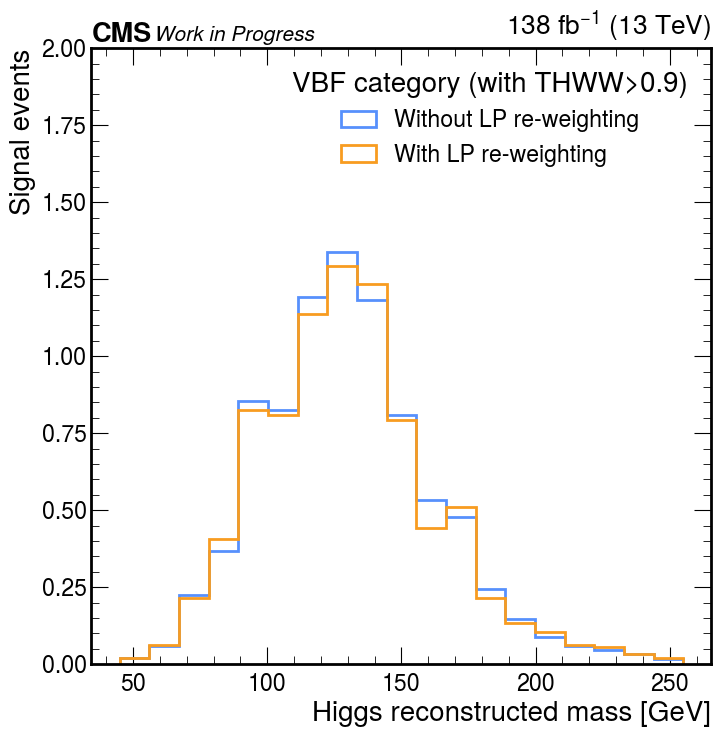

In [90]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

df = []
for year in years_LP:
    df.append(events_dict[year]["lep"]["Signal"])
df = pd.concat(df)

msk = df["THWW"]>score_thresh
df = df[msk]

fig, ax = plt.subplots(figsize=(8,8))

ax.hist(
    df["rec_higgs_m"],
    weights=df["nominal"],
    bins=np.linspace(45, 255, 20),
    label="Without LP re-weighting",
    linewidth=2,
    histtype="step",
)
ax.hist(
    df["rec_higgs_m"],
    weights=df["LP_weight_nom"],
    bins=np.linspace(45, 255, 20),
    label="With LP re-weighting",
    linewidth=2,
    histtype="step",
)


ax.legend(title=f"{cat} category (with THWW>0.9)")

ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel(f"{sample} events")

ax.set_ylim(0,2)

hep.cms.lumitext("%.0f " % get_lumi(years_LP, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_mobs_{sample}_{cat}.pdf")

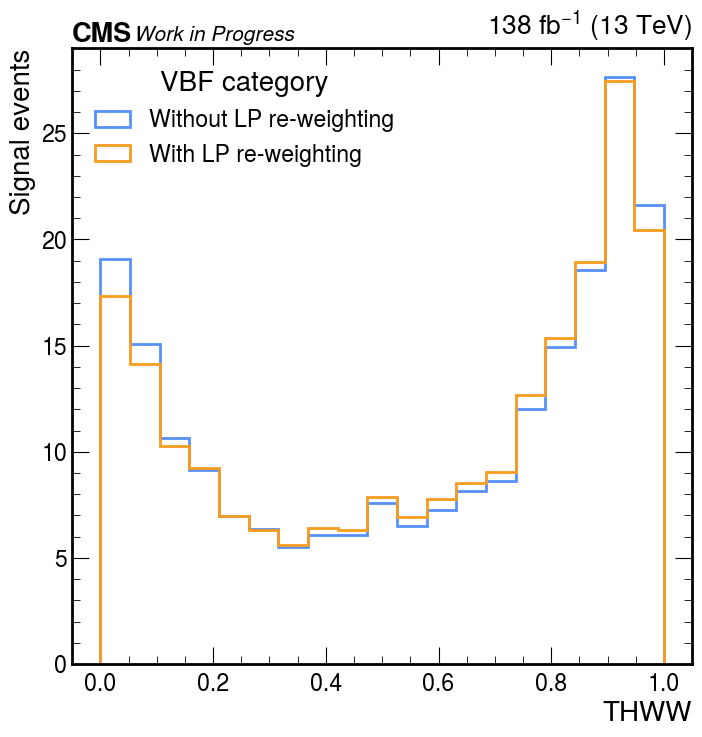

In [108]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

df = []
for year in years_LP:
    df.append(events_dict[year]["lep"]["Signal"])
df = pd.concat(df)

msk = df["THWW"]>0
df = df[msk]

fig, ax = plt.subplots(figsize=(8,8))

ax.hist(
    df["THWW"],
    weights=df["nominal"],
    bins=np.linspace(0, 1, 20),
    label="Without LP re-weighting",
    linewidth=2,
    histtype="step",
)
ax.hist(
    df["THWW"],
    weights=df["LP_weight_nom"],
    bins=np.linspace(0, 1, 20),
    label="With LP re-weighting",
    linewidth=2,
    histtype="step",
)


ax.legend(title=f"{cat} category")

ax.set_xlabel("THWW")
ax.set_ylabel(f"{sample} events")

hep.cms.lumitext("%.0f " % get_lumi(years_LP, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_THWW_{sample}_{cat}.pdf")

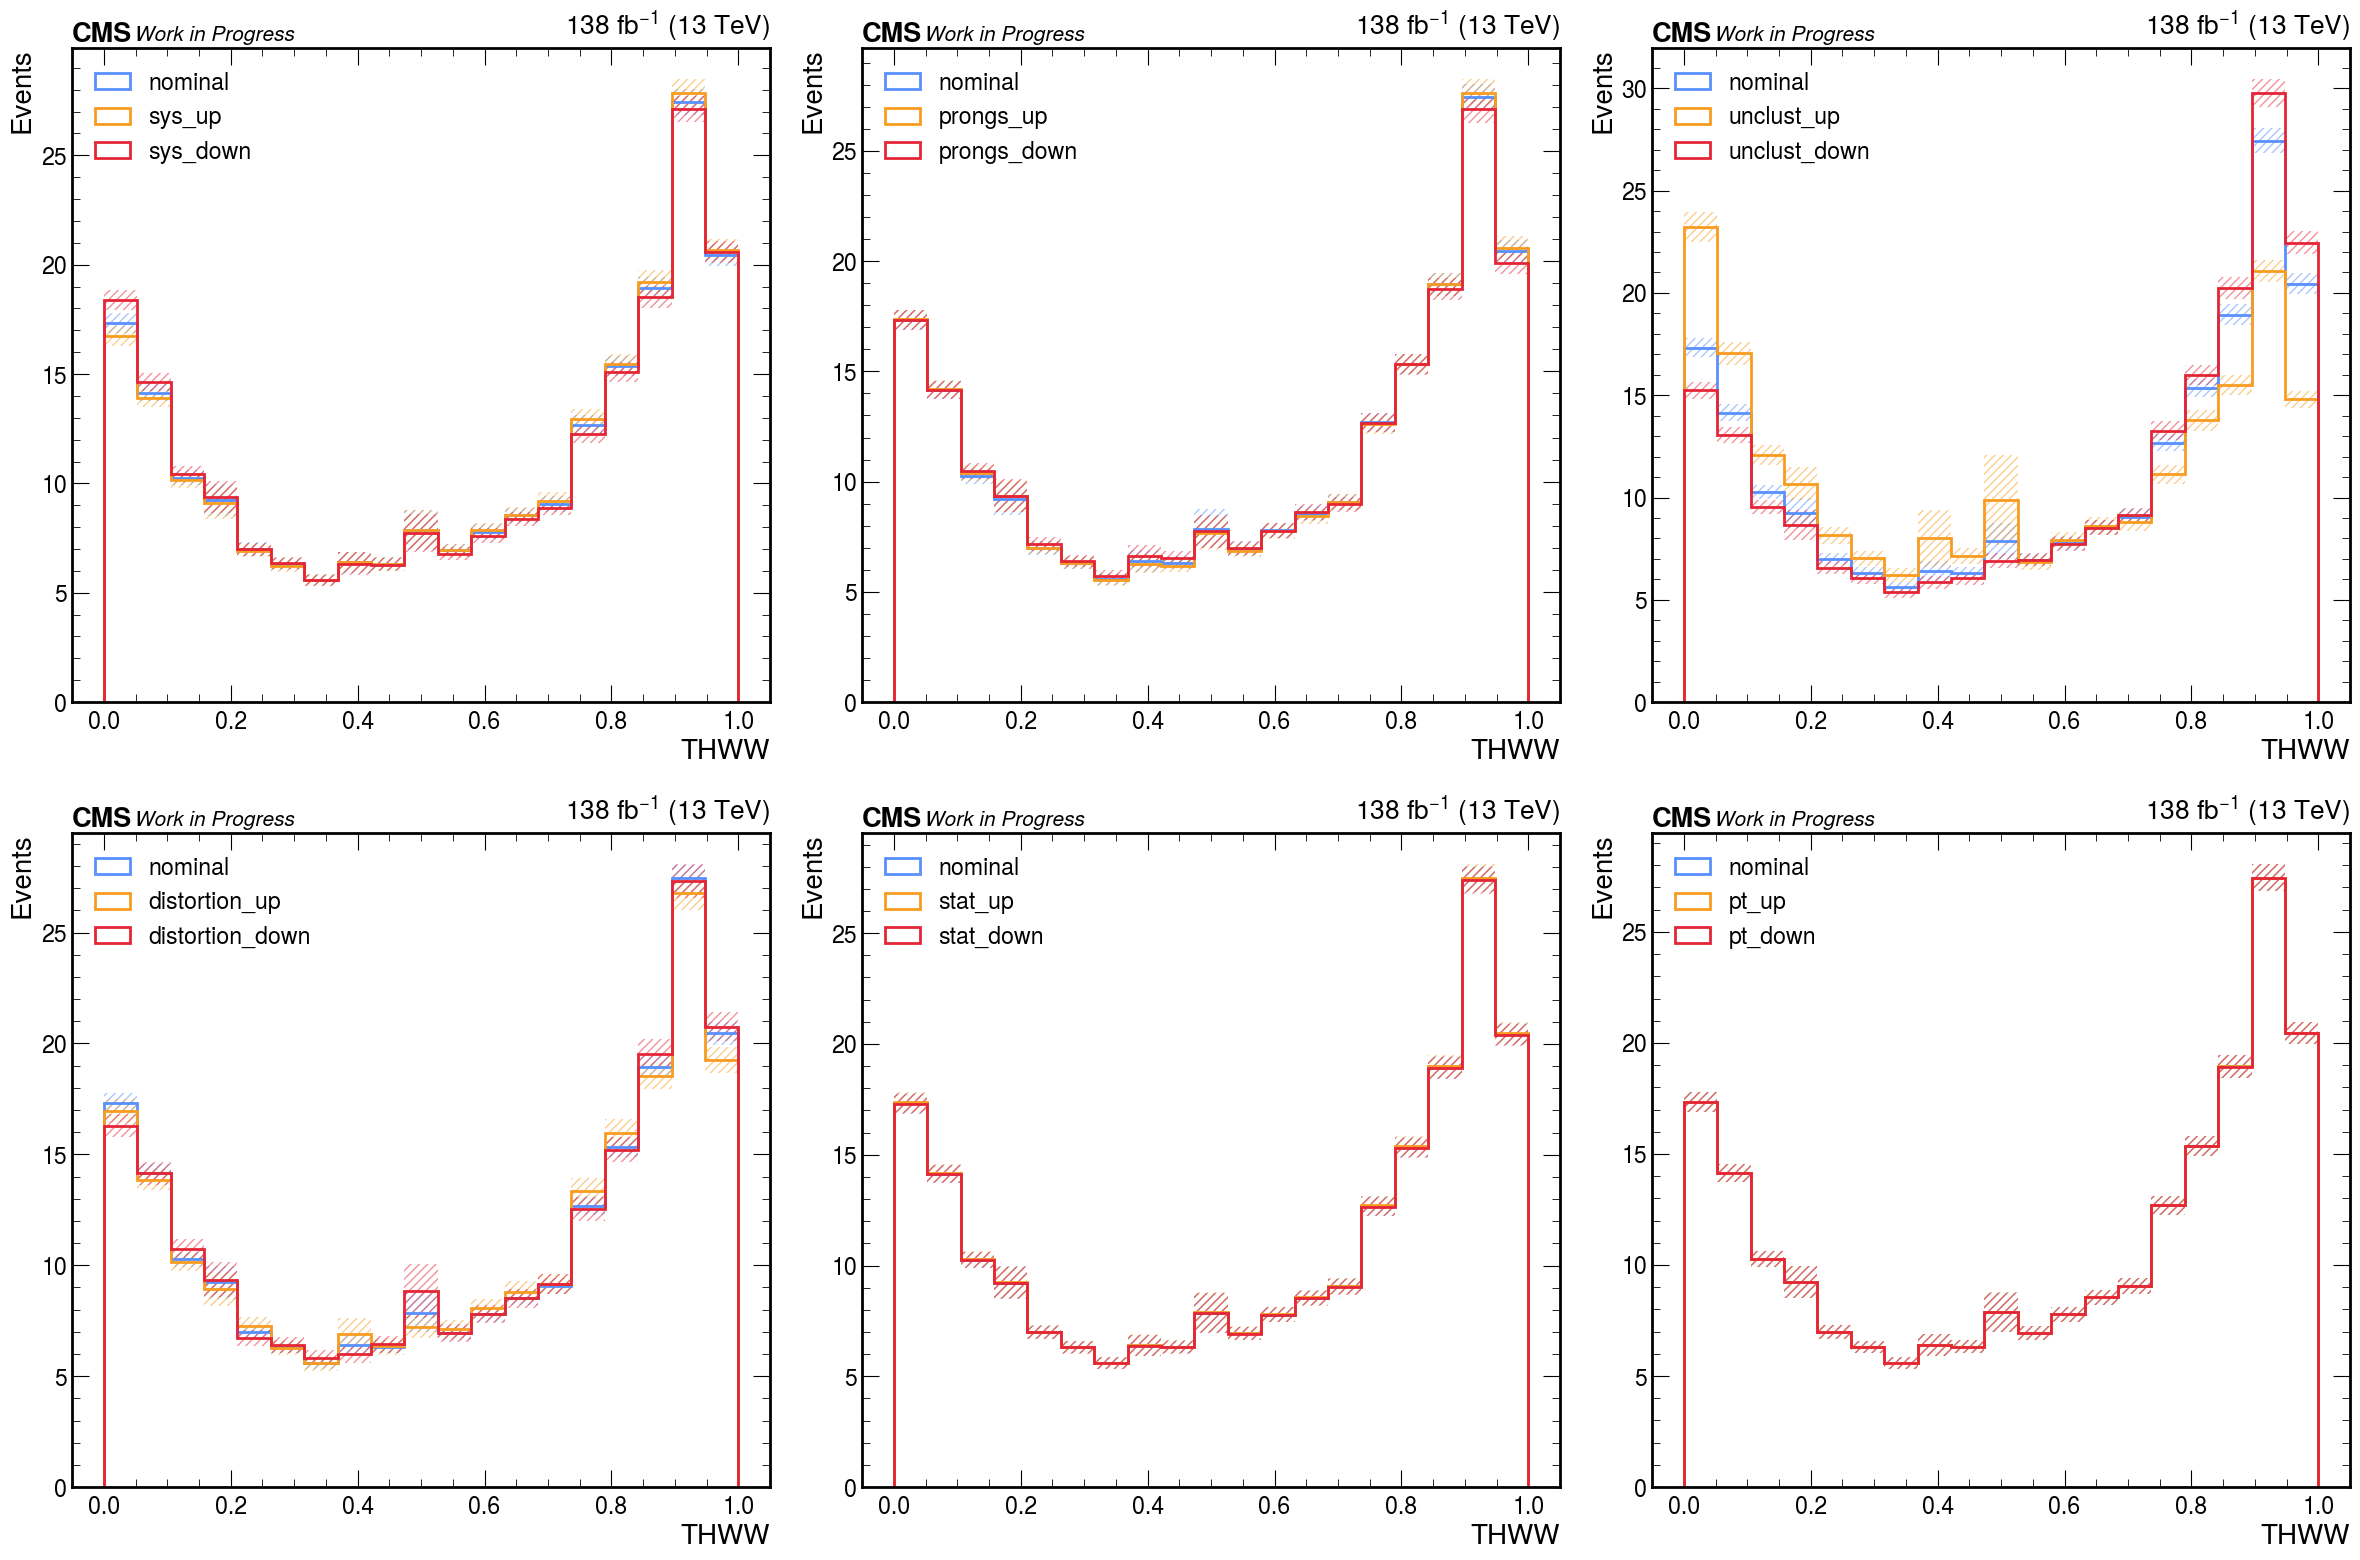

In [47]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

# Concatenate data
df = []
for year in years_LP:
    df.append(events_dict[year]["lep"]["Signal"])
df = pd.concat(df)

# Filter data
# msk = df["THWW"] > score_thresh
msk = df["THWW"] > 0
df = df[msk]

# Define systematic keys
sys_keys = ['sys', 'prongs', 'unclust', 'distortion', 'stat', 'pt']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))
axes = axes.flatten()  # Flatten to make it easier to index with sys_keys

# Iterate over each sys_key and corresponding subplot
for idx, sys_key in enumerate(sys_keys):
    ax = axes[idx]
    
    up = df[f"LP_weight_{sys_key}_up"].fillna(df[f"LP_weight_nom"])
    down = df[f"LP_weight_{sys_key}_down"].fillna(df[f"LP_weight_nom"])    
    
    dict_ = {
        "nominal": df["LP_weight_nom"],
        sys_key + "_up": up,
        sys_key + "_down": down,
#         sys_key + "_up": np.where(up>down, up, down),
#         sys_key + "_down": np.where(up<down, up, down),
    }
    
    
    for lab, w in dict_.items():

        # Histogram data and weights
        hist_values, bin_edges = np.histogram(df["THWW"], bins=np.linspace(0, 1, 20), weights=w)

        # Calculate bin centers for plotting hatch error bars
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # Statistical uncertainties: sqrt(sum of weights^2 in each bin)
        weights_squared = w ** 2
        hist_errors, _ = np.histogram(df["THWW"], bins=bin_edges, weights=weights_squared)
        hist_errors = np.sqrt(hist_errors)


        # Nominal histogram
        line = ax.hist(
            df["THWW"],
            weights=w,
            bins=np.linspace(0, 1, 20),
            label=lab,
            linewidth=2,
            histtype="step",
        )

        # Define hatch style for the error bands
        errps = {
            "hatch": "////",
            "color": line[2][0].get_edgecolor(),
            "alpha": 0.5,
            "linewidth": 0,
        }    
        ax.stairs(
            values=line[0]+hist_errors,
            baseline=line[0]-hist_errors,
            edges=bin_edges,
            **errps,
        )
    
    # Set plot labels and titles
#     ax.legend(title=f"{cat} category")
    ax.legend()    
    ax.set_xlabel("THWW")
    ax.set_ylabel("Events")

    # Add CMS text and luminosity information
    hep.cms.lumitext(f"{get_lumi(years, channels):.0f} fb$^{{-1}}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# Adjust layout and save figure
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_sig_{cat}_combined.pdf")
plt.show()

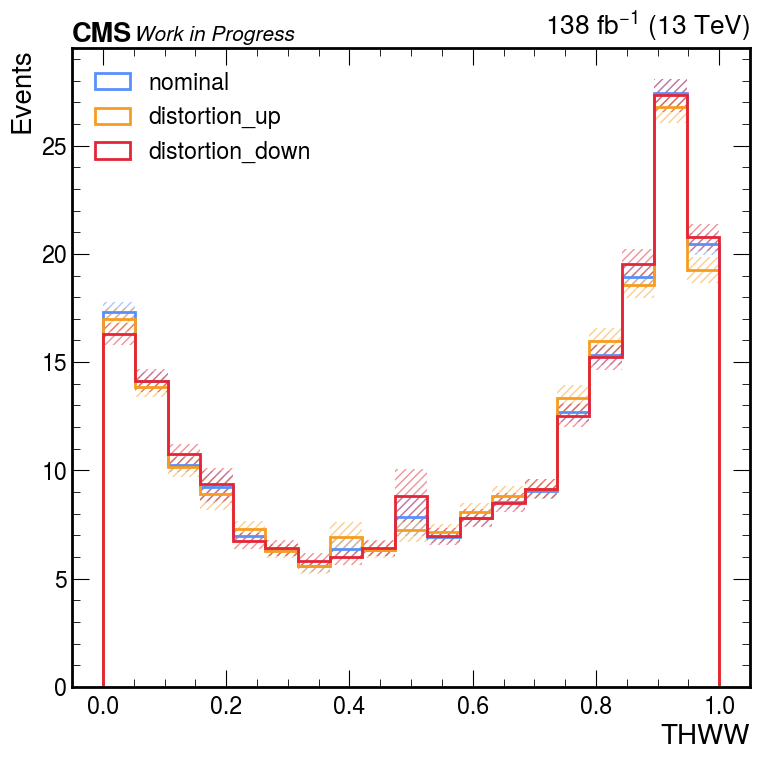

In [49]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

# Concatenate data
df = []
for year in years_LP:
    df.append(events_dict[year]["lep"]["Signal"])
df = pd.concat(df)

# Filter data
# msk = df["THWW"] > score_thresh
msk = df["THWW"] > 0
df = df[msk]

# Set up subplots
fig, ax = plt.subplots(figsize=(8, 8))

sys_key = "distortion"
    
up = df[f"LP_weight_{sys_key}_up"].fillna(df[f"LP_weight_nom"])
down = df[f"LP_weight_{sys_key}_down"].fillna(df[f"LP_weight_nom"])    

dict_ = {
    "nominal": df["LP_weight_nom"],
    sys_key + "_up": up,
    sys_key + "_down": down,
#         sys_key + "_up": np.where(up>down, up, down),
#         sys_key + "_down": np.where(up<down, up, down),
}


for lab, w in dict_.items():

    # Histogram data and weights
    hist_values, bin_edges = np.histogram(df["THWW"], bins=np.linspace(0, 1, 20), weights=w)

    # Calculate bin centers for plotting hatch error bars
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Statistical uncertainties: sqrt(sum of weights^2 in each bin)
    weights_squared = w ** 2
    hist_errors, _ = np.histogram(df["THWW"], bins=bin_edges, weights=weights_squared)
    hist_errors = np.sqrt(hist_errors)


    # Nominal histogram
    line = ax.hist(
        df["THWW"],
        weights=w,
        bins=np.linspace(0, 1, 20),
        label=lab,
        linewidth=2,
        histtype="step",
    )

    # Define hatch style for the error bands
    errps = {
        "hatch": "////",
        "color": line[2][0].get_edgecolor(),
        "alpha": 0.5,
        "linewidth": 0,
    }    
    ax.stairs(
        values=line[0]+hist_errors,
        baseline=line[0]-hist_errors,
        edges=bin_edges,
        **errps,
    )

# Set plot labels and titles
#     ax.legend(title=f"{cat} category")
ax.legend()    
ax.set_xlabel("THWW")
ax.set_ylabel("Events")

# Add CMS text and luminosity information
hep.cms.lumitext(f"{get_lumi(years, channels):.0f} fb$^{{-1}}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# Adjust layout and save figure
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_sig_{cat}_combined.pdf")
plt.show()

# Extract SF

In [30]:
df = []
for year in years_LP:
    df.append(events_dict[year]["lep"]["Signal"])
df = pd.concat(df)

if Whad == "onshell":
    msk_W = df["fj_H_VV_isVlepton"] == 0
elif Whad == "offshell":
    msk_W = df["fj_H_VV_isVlepton"] == 1
else:
    msk_W = df["fj_H_VV_isVlepton"] >= 0

is_hww_l = (df["num_m_quarks"]==0)
is_hww_lq = (df["num_m_quarks"]==1)
is_hww_lqq = (df["num_m_quarks"]==2)

# msk = (is_hww_lqq | is_hww_lq)
msk = (is_hww_lqq | is_hww_lq) & msk_W
df = df[msk]

df["LP_weight_distortion_up"] = df["LP_weight_distortion_up"].fillna(df[f"LP_weight_nom"])
df["LP_weight_distortion_down"] = df["LP_weight_distortion_down"].fillna(df[f"LP_weight_nom"])

In [31]:
print(cat, "category")

score = df["THWW"].values
score_cut = score > score_thresh

###### Use weights to compute efficiency of a cut

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = df["nominal"])

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = df["LP_weight_nom"])

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
#separately for each MC sample rather than a single 'SF'


######  Compute uncertainties on the efficiency from the various weight variations ##############

#statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
#take std dev to determine unc

nToys = LP_weights['stat_vars'].shape[1]
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = df[f"LP_weight_stat_{i}"])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = df[f"LP_weight_pt_{i}"])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

#if mean of toys is biased, also include it as an unc (should be zero)
eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))

#Other systematics come from up/down variations of the weights
# sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
sys_keys = ['sys', 'prongs', 'unclust', 'distortion']
sys_uncs = dict()

for sys in sys_keys: sys_uncs[sys] = [0.,0.]

#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(cut, weights = weights_up)
    eff_down =  np.average(cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down

for sys in sys_keys:
    unc_up, unc_down = get_uncs(score_cut, df[f"LP_weight_{sys}_up"], df[f"LP_weight_{sys}_down"], eff_rw)
    sys_uncs[sys] = [unc_up, unc_down]


#Print uncertainty breakdown
eff_str = "Calibrated efficiency: %.5f +/- %.5f (stat) +/- %.5f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
THWW_str = "THWW SF: %.5f +/- %.5f (stat) +/- %.5f (pt)" % (SF, eff_stat_unc/eff_rw, eff_pt_unc/eff_rw)
tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

for sys in sys_keys:
    eff_str += " %.5f/%.5f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
    THWW_str += " %.5f/%.5f (%s)" % (sys_uncs[sys][0]/eff_rw, sys_uncs[sys][1]/eff_rw, sys)
    
    up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
    down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
    tot_unc_up += up_var**2
    tot_unc_down += down_var**2

tot_unc_up = tot_unc_up**0.5
tot_unc_down = tot_unc_down**0.5

#Print final calibrated efficiency and total uncertaintiy
eff_str += "\n Original %.3f, Calibrated %.3f +%.3f/-%.3f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

f_ratio.Close()

print(eff_str)
print()
print(THWW_str)
print()
print(f"THWW SF + tot_unc_up - tot_unc_down: {SF:.3f} + {(tot_unc_up/eff_rw):.3f} - {(tot_unc_down/eff_rw):.3f}")
print("---------------------------------")    

VBF category
Nominal efficiency 0.210, Corrected efficiency 0.203, SF (corrected / nom) 0.967
Stat variation toys eff. avg 0.203, std dev 0.001
Pt variation toys eff. avg 0.203, std dev 0.000
Calibrated efficiency: 0.20298 +/- 0.00146 (stat) +/- 0.00005 (pt) 0.00232/-0.00040 (sys) 0.00160/-0.00459 (prongs) -0.05210/0.01900 (unclust) -0.00759/0.00140 (distortion)
 Original 0.210, Calibrated 0.203 +0.019/-0.053 


THWW SF: 0.96674 +/- 0.00719 (stat) +/- 0.00024 (pt) 0.01144/-0.00197 (sys) 0.00788/-0.02263 (prongs) -0.25666/0.09361 (unclust) -0.03740/0.00690 (distortion)

THWW SF + tot_unc_up - tot_unc_down: 0.967 + 0.095 - 0.260
---------------------------------


# Lepton removal checks

In [41]:
pd.options.mode.copy_on_write = False
pd.options.mode.chained_assignment = None

years_LP = [
    "2018",
#     "2017",
#     "2016",
#     "2016APV",
]
channels_LP = [
    "lep",
]

sample = "Signal"
# sample = "VBF"
# sample = "ggF"
# sample = "ttH"
# events_dict = combine_channels(years, channels, events_dict, sample)

Whad = ""
save_dict = False


LPR = {}
for DR in [
    "0001", 
    "0005", 
    "001", 
    "005", 
    "01", 
    "02", 
    "05", 
    "1", 
    "2",
]:
    print(DR)
    for ch in channels_LP:

#         df = events_dict[year][ch][sample]
        df = pd.read_parquet(glob.glob(f"outfiles_{DR}/0-*.parquet"))

        if Whad == "onshell":
            msk_W = df["fj_H_VV_isVlepton"] == 0
        elif Whad == "offshell":
            msk_W = df["fj_H_VV_isVlepton"] == 1
        else:
            msk_W = df["fj_H_VV_isVlepton"] >= 0
            
        is_hww_l = (df["num_m_quarks"]==0)
        is_hww_lq = (df["num_m_quarks"]==1)
        is_hww_lqq = (df["num_m_quarks"]==2)

        msk = (is_hww_lqq | is_hww_lq) & msk_W
        df = df[msk]

        # (1) PFcands
        pxs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("px")].values
        pys = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("py")].values
        pzs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("pz")].values
        Es = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("energy")].values

        pf_cands = np.stack([pxs,pys,pzs,Es], axis=-1)

        # (2) ak8 jet, and the THWW score
        ak8_jets = np.stack([df["LP_fj_pt"].values, df["LP_fj_eta"].values, df["LP_fj_phi"].values, df["LP_fj_mass"].values], axis=-1)

        # (3) genQuarks
        etas = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("eta")].values
        phis = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("phi")].values

        gen_parts_eta_phi = np.stack([etas,phis], axis=-1) 
        
        ############## RUN LPR
        #use small number of events for the example, but generally advisable to use larger sample
        max_evts = 10000000_000

        import sys, os
        sys.path.insert(0, '')
        sys.path.append("LundReweighting")
        from LundReweighting.utils.Utils import *

        """ An example how to use the Lund Plane reweighting  code. 
        Computes reweighting factors for an example signal. 
        Uses them to compute the efficiency and uncertainty of a given substructure cut"""

        ######################## Setup 

        #Input file 
        fname = "LundReweighting/data/example_signal.h5"
        f_ratio_name = f'LundReweighting/data/ratio_{year.replace("APV", "")}.root'

        f_sig = h5py.File(fname, "r")
        f_ratio = ROOT.TFile.Open(f_ratio_name)

        #Class to help read input dataset 
        d = Dataset(f_sig, dtype = 1)
        d.compute_obs()

        #Main class for reweighting utilities
        LP_rw = LundReweighter(f_ratio = f_ratio)

        ################### Compute reweighting factors

        #PF candidates in the AK8 jet for each event (list of (px,py,pz,E))
        pf_cands = pf_cands[:max_evts]
        print("Running on %i events" % len(pf_cands))

        #Generator level quarks from hard process 
        gen_parts_eta_phi = gen_parts_eta_phi[:max_evts]

        #4 vector of AK8 jets we are calibrating
        ak8_jets = ak8_jets[:max_evts]

        #Compute reweighting factors and all systematic variations
        LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets)

        #Fraction of prongs that are not well matched to subjets (want this to be low)
        print("Bad match frac %.2f" % np.mean(LP_weights['bad_match']))
        #Fraction of prongs that are still not well matched after reclustering with varied number of prongs
        print("Reclustered bad match frac %.2f" % np.mean(LP_weights['reclust_still_bad_match']))
        
        df["LP_weights"] = LP_weights["nom"]
        LPR[DR] = df
    print("------------------------------")
#     break

0001
Running on 3374 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.46
Reclustered bad match frac 0.28
------------------------------
0005
Running on 3374 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.18
Reclustered bad match frac 0.11
------------------------------
001
Running on 3374 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.17
Reclustered bad match frac 0.11
------------------------------
005
Running on 3374 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero 

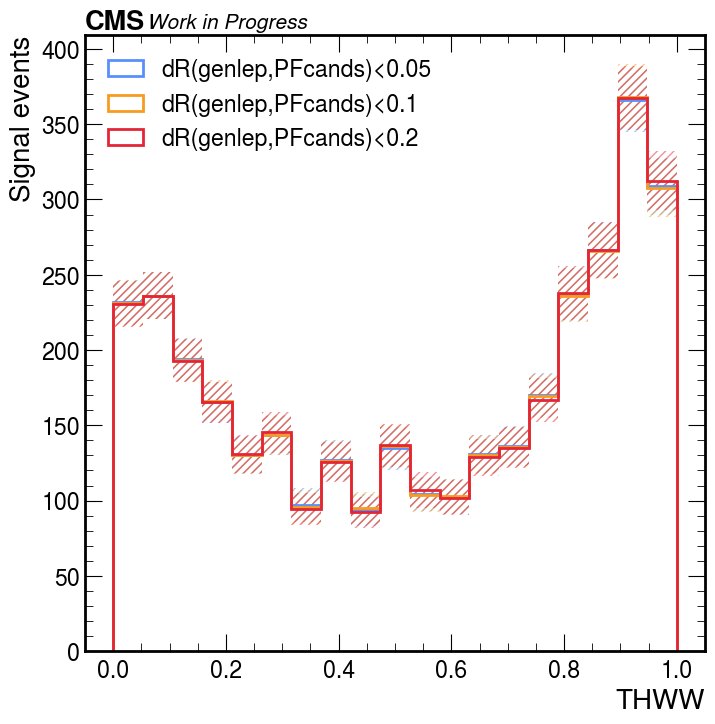

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special


%matplotlib inline
plt.rcParams.update({"font.size": 20})

def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]


# --------------------------------

fig, ax = plt.subplots(figsize=(8, 8))
for DR in [
    "005", 
    "01", 
    "02",
]:
    df = LPR[DR]
    df["THWW"] = get_finetuned_score(df, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")
    
    # Histogram data and weights
    hist_values, bin_edges = np.histogram(df["THWW"], bins=np.linspace(0, 1, 20), weights=df["LP_weights"])
    
    # Calculate bin centers for plotting hatch error bars
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Statistical uncertainties: sqrt(sum of weights^2 in each bin)
    weights_squared = df["LP_weights"] ** 2
    hist_errors, _ = np.histogram(df["THWW"], bins=bin_edges, weights=weights_squared)
    hist_errors = np.sqrt(hist_errors)
    
    # Plot histogram line
    line = ax.hist(
        df["THWW"],
        weights=df["LP_weights"],
        bins=bin_edges,
        label=f"dR(genlep,PFcands)<{lab_dict[DR]}",
        linewidth=2,
        histtype="step",
    )
    
    # Define hatch style for the error bands
    errps = {
        "hatch": "////",
        "color": line[2][0].get_edgecolor(),
        "alpha": 0.5,
        "linewidth": 0,
    }    
    ax.stairs(
        values=line[0]+hist_errors,
        baseline=line[0]-hist_errors,
        edges=bin_edges,
        **errps,
    )

ax.legend()
ax.set_xlabel("THWW")
ax.set_ylabel(f"{sample} events")

# CMS styling
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# Save figure if needed
# plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_THWW_{sample}_{cat}.pdf")
plt.show()


In [95]:
100_000//100

1000

In [100]:
Njobs = 1_000
nruns_per_condor_job = 10
for jobid in range(0, Njobs, nruns_per_condor_job):
    print(jobid, jobid+nruns_per_condor_job-1)

0 9
10 19
20 29
30 39
40 49
50 59
60 69
70 79
80 89
90 99
100 109
110 119
120 129
130 139
140 149
150 159
160 169
170 179
180 189
190 199
200 209
210 219
220 229
230 239
240 249
250 259
260 269
270 279
280 289
290 299
300 309
310 319
320 329
330 339
340 349
350 359
360 369
370 379
380 389
390 399
400 409
410 419
420 429
430 439
440 449
450 459
460 469
470 479
480 489
490 499
500 509
510 519
520 529
530 539
540 549
550 559
560 569
570 579
580 589
590 599
600 609
610 619
620 629
630 639
640 649
650 659
660 669
670 679
680 689
690 699
700 709
710 719
720 729
730 739
740 749
750 759
760 769
770 779
780 789
790 799
800 809
810 819
820 829
830 839
840 849
850 859
860 869
870 879
880 889
890 899
900 909
910 919
920 929
930 939
940 949
950 959
960 969
970 979
980 989
990 999
